# <b>Assignment : DT</b>

# <font color='red'> <b>Task - 1</b></font>

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from prettytable import PrettyTable

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv('preprocessed_data.csv', nrows=50000)
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [3]:
data.shape

(50000, 9)

In [4]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

print(X.shape, y.shape)

(50000, 8) (50000,)


In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

(40000, 8) (40000,)
(10000, 8) (40000,)


### 1. Essay

In [6]:
tfidf_model = TfidfVectorizer(min_df=10, max_features=5000)
tfidf_model.fit(X_train['essay'].values)

X_train_essay_tfidf = tfidf_model.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_model.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(40000, 5000) (40000,)
(10000, 5000) (10000,)


In [7]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [8]:
tfidf_w2v_vectors_train = []
for sentence in tqdm_notebook(X_train['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

In [9]:
tfidf_w2v_vectors_test = []
for sentence in tqdm_notebook(X_test['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

In [10]:
X_train_tfidf_w2v = pd.DataFrame(tfidf_w2v_vectors_train)
X_test_tfidf_w2v = pd.DataFrame(tfidf_w2v_vectors_test)

print(X_train_tfidf_w2v.shape)
print(X_test_tfidf_w2v.shape)

(40000, 300)
(10000, 300)


### 2. Teacher Prefix

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)

(40000, 5) (40000,)
(10000, 5) (10000,)


### 3. Project Grade Category

In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)

(40000, 4) (40000,)
(10000, 4) (10000,)


### 4. School State

In [13]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)

(40000, 51) (40000,)
(10000, 51) (10000,)


### 5. Categories

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_subject_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_subject_ohe = vectorizer.transform(X_test['clean_categories'].values)

print(X_train_subject_ohe.shape, y_train.shape)
print(X_test_subject_ohe.shape, y_test.shape)

(40000, 9) (40000,)
(10000, 9) (10000,)


### 6. Subcategories

In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

X_train_subject_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_subject_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print(X_train_subject_subcategories_ohe.shape, y_train.shape)
print(X_train_subject_subcategories_ohe.shape, y_test.shape)

(40000, 30) (40000,)
(40000, 30) (10000,)


### 7. Price

In [16]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_temp = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_temp = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_normalized = X_train_price_temp.reshape(-1,1)
X_test_price_normalized = X_test_price_temp.reshape(-1,1)

print(X_train_price_normalized.shape, y_train.shape)
print(X_test_price_normalized.shape, y_train.shape)

(40000, 1) (40000,)
(10000, 1) (40000,)


### 8. Teacher's previous projects

In [17]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_price_temp = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_price_temp = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_temp.reshape(-1,1)
X_test_prev_proj_norm = X_test_price_temp.reshape(-1,1)

print(X_train_prev_proj_norm.shape, y_train.shape)
print(X_test_prev_proj_norm.shape, y_train.shape)

(40000, 1) (40000,)
(10000, 1) (40000,)


### 9. Sentiment score

In [18]:
def sentiment_analyzer(col):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(col)
    return list(sentiment.values())

X_train_sentiment_temp = list(X_train['essay'].apply(sentiment_analyzer))
X_test_sentiment_temp = list(X_test['essay'].apply(sentiment_analyzer))

X_train_sentiment = pd.DataFrame(X_train_sentiment_temp, columns=['neg', 'neu', 'pos', 'compound'])
X_test_sentiment = pd.DataFrame(X_test_sentiment_temp, columns=['neg', 'neu', 'pos', 'compound'])

print(X_train_sentiment.shape)
print(X_test_sentiment.shape)

(40000, 4)
(10000, 4)


In [19]:
# Set-1
X_train_tfidf = hstack((X_train_teacher_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_subject_ohe, X_train_subject_subcategories_ohe, X_train_price_normalized, X_train_prev_proj_norm, X_train_essay_tfidf, X_train_sentiment)).tocsr()
X_test_tfidf = hstack((X_test_teacher_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_subject_ohe, X_test_subject_subcategories_ohe, X_test_price_normalized, X_test_prev_proj_norm, X_test_essay_tfidf, X_test_sentiment)).tocsr()

print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

(40000, 5105) (40000,)
(10000, 5105) (10000,)


In [20]:
# Set-2
X_train_tfidf_w2v = hstack((X_train_teacher_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_subject_ohe, X_train_subject_subcategories_ohe, X_train_price_normalized, X_train_prev_proj_norm, X_train_tfidf_w2v, X_train_sentiment)).tocsr()
X_test_tfidf_w2v = hstack((X_test_teacher_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_subject_ohe, X_test_subject_subcategories_ohe, X_test_price_normalized, X_test_prev_proj_norm, X_test_tfidf_w2v, X_test_sentiment)).tocsr()

print(X_train_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)

(40000, 405) (40000,)
(10000, 405) (10000,)


### Set-1

In [21]:
# finding best hyperparameters for set-1
params_tfidf = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

clf_tfidf = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_tfidf, scoring='roc_auc', cv=5, return_train_score=True)
clf_tfidf.fit(X_train_tfidf, y_train)

#clf.cv_results_
print(clf_tfidf.best_params_)
print(clf_tfidf.best_score_)

{'max_depth': 10, 'min_samples_split': 500}
0.6358749977613062


In [22]:
test_score_tfidf = clf_tfidf.cv_results_['mean_test_score']
train_score_tfidf = clf_tfidf.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_tfidf_hm = pd.DataFrame(np.array_split(train_score_tfidf, 4)).transpose()
test_score_tfidf_hm = pd.DataFrame(np.array_split(test_score_tfidf, 4)).transpose()

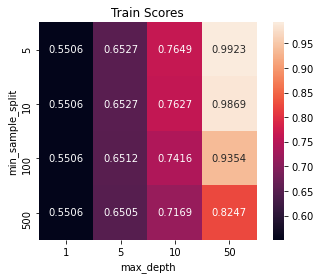

In [23]:
plt.figure()
sns.heatmap(train_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['max_depth'], yticklabels=params_tfidf['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('Train Scores')
plt.show()

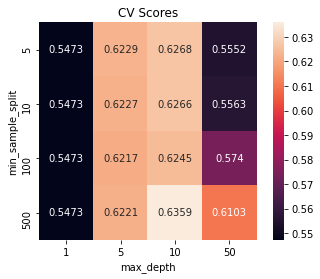

In [24]:
plt.figure()
sns.heatmap(test_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['max_depth'], yticklabels=params_tfidf['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('CV Scores')
plt.show()

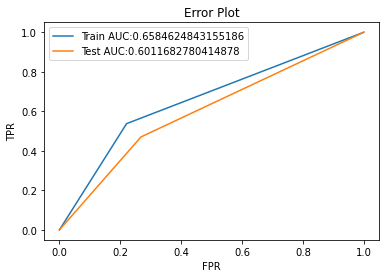

In [25]:
# training best model on best hyperparameters for set-1
best_model_tfidf = DecisionTreeClassifier(max_depth=clf_tfidf.best_params_['max_depth'], min_samples_split=clf_tfidf.best_params_['min_samples_split'], class_weight='balanced')
best_model_tfidf.fit(X_train_tfidf, y_train)

y_train_predict_tfidf = best_model_tfidf.predict(X_train_tfidf)
y_test_predict_tfidf = best_model_tfidf.predict(X_test_tfidf)

fpr1_tfidf, tpr1_tfidf, thresholds1_tfidf = roc_curve(y_train, y_train_predict_tfidf)
fpr2_tfidf, tpr2_tfidf, thresholds2_tfidf = roc_curve(y_test, y_test_predict_tfidf)

plt.figure()
plt.plot(fpr1_tfidf, tpr1_tfidf, label='Train AUC:'+str(auc(fpr1_tfidf,tpr1_tfidf)))
plt.plot(fpr2_tfidf, tpr2_tfidf, label='Test AUC:'+str(auc(fpr2_tfidf,tpr2_tfidf)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

[[1172  429]
 [4449 3950]]


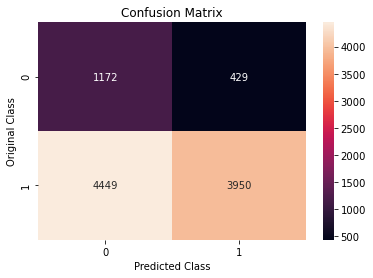

In [26]:
cm_tfidf = confusion_matrix(y_test, y_test_predict_tfidf)
print(cm_tfidf)

plt.figure()
sns.heatmap(cm_tfidf, annot=True, fmt='1')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Confusion Matrix')
plt.show()

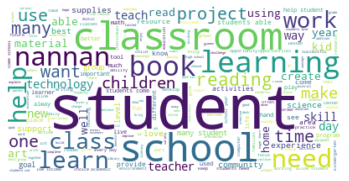

In [27]:
# analysis on False Positive datapoints
false_pos_idx_tfidf = np.where((y_test != y_test_predict_tfidf) & y_test_predict_tfidf==1)
false_pos_sent_tfidf = X_test['essay'].iloc[false_pos_idx_tfidf]
words_tfidf = ' '.join(false_pos_sent_tfidf)
stopwords = set(STOPWORDS)

wc_tfidf = WordCloud(background_color='white', max_words=len(words_tfidf), stopwords=stopwords)
wc_tfidf.generate(words_tfidf)
plt.imshow(wc_tfidf, interpolation='bilinear')
plt.axis('off')
plt.show()

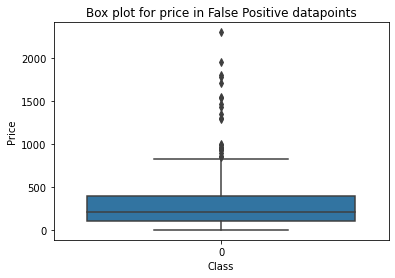

In [28]:
plt.figure()
sns.boxplot(x=y_test[false_pos_idx_tfidf], y=X_test['price'].iloc[false_pos_idx_tfidf])
plt.xlabel('Class')
plt.ylabel('Price')
plt.title('Box plot for price in False Positive datapoints')
plt.show()

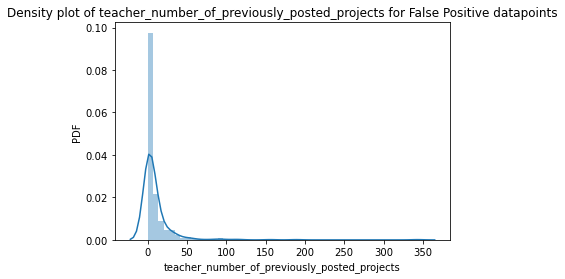

In [29]:
plt.figure()
sns.distplot(X_test['teacher_number_of_previously_posted_projects'].iloc[false_pos_idx_tfidf])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('PDF')
plt.title('Density plot of teacher_number_of_previously_posted_projects for False Positive datapoints')
plt.show()

### Set-2

In [30]:
# finding best hyperparameter for set-2
params_w2v = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

clf_w2v = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_w2v, scoring='roc_auc', cv=5, return_train_score=True)
clf_w2v.fit(X_train_tfidf_w2v, y_train)

#clf1.cv_results_
print(clf_w2v.best_params_)
print(clf_w2v.best_score_)

{'max_depth': 5, 'min_samples_split': 500}
0.6221006555972606


In [31]:
test_score_w2v = clf_w2v.cv_results_['mean_test_score']
train_score_w2v = clf_w2v.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_hm_w2v = pd.DataFrame(np.array_split(train_score_w2v, 4)).transpose()
test_score_hm_w2v = pd.DataFrame(np.array_split(test_score_w2v, 4)).transpose()

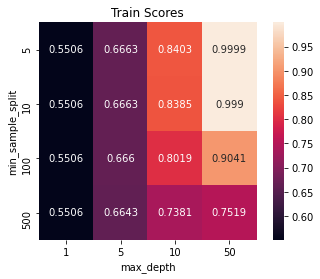

In [32]:
plt.figure()
sns.heatmap(train_score_hm_w2v, annot=True, square=True, xticklabels=params_w2v['max_depth'], yticklabels=params_w2v['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('Train Scores')
plt.show()

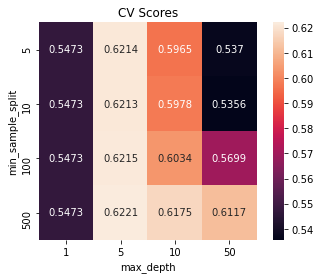

In [33]:
plt.figure()
sns.heatmap(test_score_hm_w2v, annot=True, square=True, xticklabels=params_w2v['max_depth'], yticklabels=params_w2v['min_samples_split'], fmt='0.4')
plt.xlabel('max_depth')
plt.ylabel('min_sample_split')
plt.title('CV Scores')
plt.show()

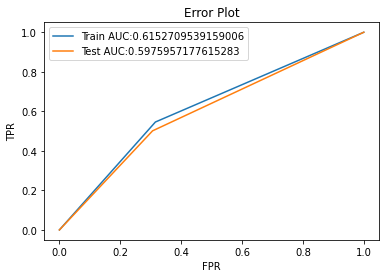

In [34]:
# training best model on best hyperparameters on set-2
best_model_w2v = DecisionTreeClassifier(max_depth=clf_w2v.best_params_['max_depth'], min_samples_split=clf_w2v.best_params_['min_samples_split'], class_weight='balanced')
best_model_w2v.fit(X_train_tfidf_w2v, y_train)

y_train_predict_w2v = best_model_w2v.predict(X_train_tfidf_w2v)
y_test_predict_w2v = best_model_w2v.predict(X_test_tfidf_w2v)

fpr1_w2v, tpr1_w2v, thresholds1_w2v = roc_curve(y_train, y_train_predict_w2v)
fpr2_w2v, tpr2_w2v, thresholds2_w2v = roc_curve(y_test, y_test_predict_w2v)

plt.figure()
plt.plot(fpr1_w2v, tpr1_w2v, label='Train AUC:'+str(auc(fpr1_w2v,tpr1_w2v)))
plt.plot(fpr2_w2v, tpr2_w2v, label='Test AUC:'+str(auc(fpr2_w2v,tpr2_w2v)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

[[1111  490]
 [4189 4210]]


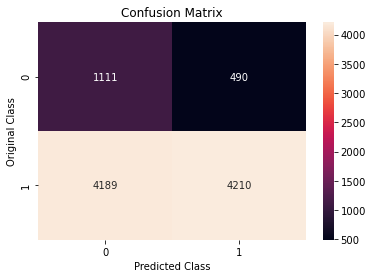

In [35]:
cm_w2v = confusion_matrix(y_test, y_test_predict_w2v)
print(cm_w2v)

plt.figure()
sns.heatmap(cm_w2v, annot=True, fmt='1')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Confusion Matrix')
plt.show()

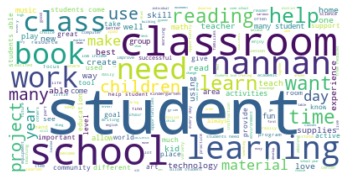

In [36]:
# analysis on False Positive datapoints
false_pos_idx_w2v = np.where((y_test != y_test_predict_w2v) & y_test_predict_w2v==1)
false_pos_sent_w2v = X_test['essay'].iloc[false_pos_idx_w2v]
words_w2v = ' '.join(false_pos_sent_w2v)
stopwords = set(STOPWORDS)

wc_w2v = WordCloud(background_color='white', max_words=len(words_w2v), stopwords=stopwords)
wc_w2v.generate(words_w2v)
plt.imshow(wc_w2v, interpolation='bilinear')
plt.axis('off')
plt.show()

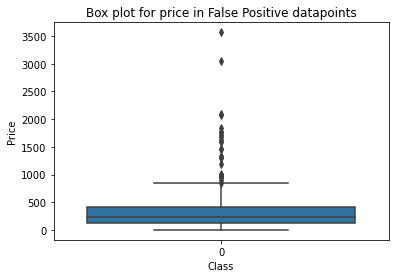

In [37]:
plt.figure()
sns.boxplot(x=y_test[false_pos_idx_w2v], y=X_test['price'].iloc[false_pos_idx_w2v])
plt.xlabel('Class')
plt.ylabel('Price')
plt.title('Box plot for price in False Positive datapoints')
plt.show()

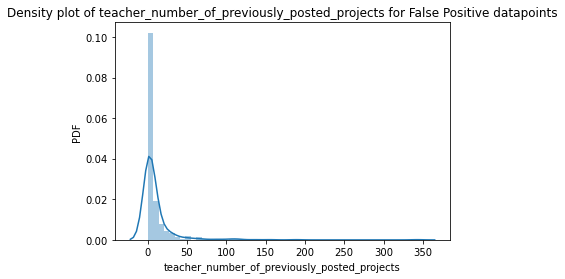

In [38]:
plt.figure()
sns.distplot(X_test['teacher_number_of_previously_posted_projects'].iloc[false_pos_idx_w2v])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('PDF')
plt.title('Density plot of teacher_number_of_previously_posted_projects for False Positive datapoints')
plt.show()

# <font color='red'><b> Task - 2 </b></font>

For this task consider **set-1** features.

*  Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM).
*  You need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  **Note**: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [39]:
# training DT for feature selection
params_fs = {'min_samples_split': [5, 10, 100, 500]}

clf_fs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_fs, scoring='roc_auc', cv=5, return_train_score=True)
clf_fs.fit(X_train_tfidf, y_train)
print(clf_fs.best_params_)

{'min_samples_split': 500}


In [41]:
# training best model with best hyperparameters
best_model_fs = DecisionTreeClassifier(min_samples_split=clf_fs.best_params_['min_samples_split'], class_weight='balanced')
best_model_fs.fit(X_train_tfidf, y_train)

imp_features = best_model_fs.feature_importances_

# https://www.geeksforgeeks.org/python-index-of-non-zero-elements-in-python-list/
imp_features_idx = [idx for idx, val in enumerate(imp_features) if val != 0]
print(imp_features_idx)

[22, 86, 99, 100, 113, 120, 132, 136, 137, 138, 147, 155, 163, 174, 176, 183, 206, 209, 239, 257, 259, 282, 302, 304, 317, 326, 338, 344, 345, 354, 367, 389, 393, 400, 430, 443, 464, 526, 535, 538, 539, 541, 542, 559, 570, 588, 593, 624, 652, 662, 670, 688, 717, 737, 780, 783, 806, 811, 836, 845, 846, 850, 864, 869, 885, 899, 900, 919, 976, 983, 1008, 1023, 1026, 1045, 1059, 1113, 1138, 1163, 1244, 1250, 1279, 1314, 1315, 1323, 1326, 1333, 1338, 1340, 1366, 1371, 1426, 1427, 1433, 1444, 1445, 1455, 1458, 1461, 1487, 1509, 1517, 1520, 1524, 1532, 1546, 1556, 1671, 1687, 1698, 1732, 1734, 1742, 1770, 1773, 1792, 1802, 1818, 1819, 1854, 1881, 1928, 1944, 1949, 1963, 1975, 2002, 2011, 2019, 2032, 2073, 2074, 2111, 2116, 2129, 2133, 2150, 2172, 2188, 2199, 2202, 2221, 2236, 2243, 2247, 2251, 2258, 2270, 2275, 2283, 2292, 2300, 2303, 2309, 2313, 2333, 2361, 2388, 2396, 2415, 2423, 2439, 2460, 2485, 2486, 2490, 2496, 2497, 2504, 2507, 2520, 2524, 2541, 2579, 2580, 2584, 2585, 2593, 2594, 2595

In [42]:
# https://cmdlinetips.com/2019/07/how-to-slice-rows-and-columns-of-sparse-matrix-in-python/
X_train_imp = X_train_tfidf[:, imp_features_idx].todense()
print(X_train_imp.shape)
X_test_imp = X_test_tfidf[:, imp_features_idx].todense()
print(X_test_imp.shape)

(40000, 353)
(10000, 353)


In [43]:
# training Logistic Regression on selected features
lr_params = {'C':[10**x for x in range(-2, 7)]}
log_reg = GridSearchCV(LogisticRegression(class_weight='balanced'), lr_params, scoring='roc_auc', cv=5, return_train_score=True)
log_reg.fit(X_train_imp, y_train)
print(log_reg.best_params_)

{'C': 10000}


In [44]:
best_model_fs = LogisticRegression(C=log_reg.best_params_['C'], class_weight='balanced')
best_model_fs.fit(X_train_imp, y_train)

y_final_train = best_model_fs.predict(X_train_imp)
y_final_test = best_model_fs.predict(X_test_imp)

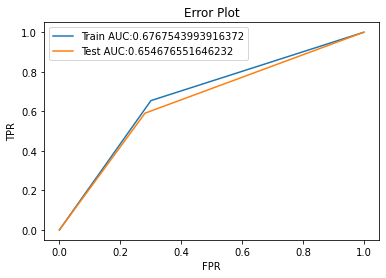

In [45]:
fpr1_fs, tpr1_fs, thresholds1_fs = roc_curve(y_train, y_final_train)
fpr2_fs, tpr2_fs, thresholds2_fs = roc_curve(y_test, y_final_test)

plt.figure()
plt.plot(fpr1_fs, tpr1_fs, label='Train AUC:'+str(auc(fpr1_fs,tpr1_fs)))
plt.plot(fpr2_fs, tpr2_fs, label='Test AUC:'+str(auc(fpr2_fs,tpr2_fs)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

[[1151  450]
 [3440 4959]]


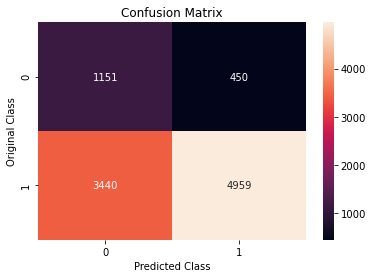

In [46]:
cm_fs = confusion_matrix(y_test, y_final_test)
print(cm_fs)

plt.figure()
sns.heatmap(cm_fs, annot=True, fmt='1')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Confusion Matrix')
plt.show()

In [47]:
table = PrettyTable()
table.field_names=('Vectorizer', 'Hyper-Parameter', 'AUC')
table.add_row(['TFIDF', str('Depth: ' + str(clf_tfidf.best_params_['max_depth']) + ' Split: ' +str(clf_tfidf.best_params_['min_samples_split'])), auc(fpr2_tfidf,tpr2_tfidf)])
table.add_row(['TFIDF_W2V', str('Depth: ' + str(clf_w2v.best_params_['max_depth']) + ' Split: ' +str(clf_w2v.best_params_['min_samples_split'])), auc(fpr2_w2v,tpr2_w2v)])
table.add_row(['Log Reg with Feature Selection',str('C: '+str(log_reg.best_params_['C'])), auc(fpr2_fs,tpr2_fs)])
print(table)

+--------------------------------+----------------------+--------------------+
|           Vectorizer           |   Hyper-Parameter    |        AUC         |
+--------------------------------+----------------------+--------------------+
|             TFIDF              | Depth: 10 Split: 500 | 0.6011682780414878 |
|           TFIDF_W2V            | Depth: 5 Split: 500  | 0.5975957177615283 |
| Log Reg with Feature Selection |       C: 10000       | 0.654676551646232  |
+--------------------------------+----------------------+--------------------+
